In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 500
test_size = 100
full_size = train_size + test_size
return_day = 10

rolling_std_dev_size = 20
extreme_multiplier = 1

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [2, 5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

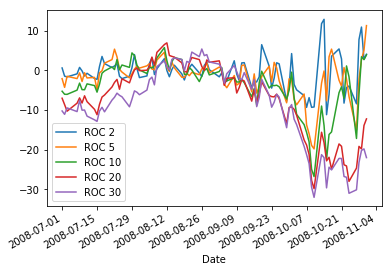

In [9]:
data['2008-07': '2008-10'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

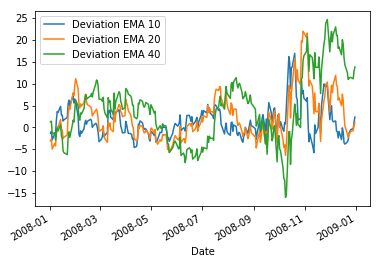

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
    data[f'MACD hist ({i}, {j}, {k})'] = macdhist

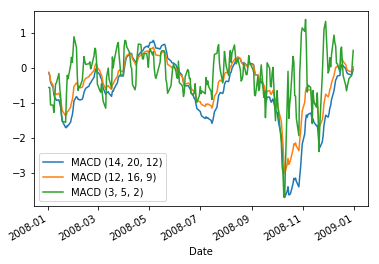

In [13]:
data['2008'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [14]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

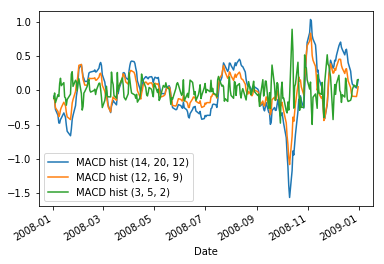

In [15]:
data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

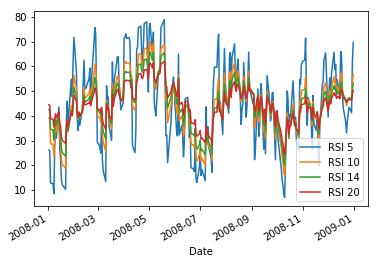

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

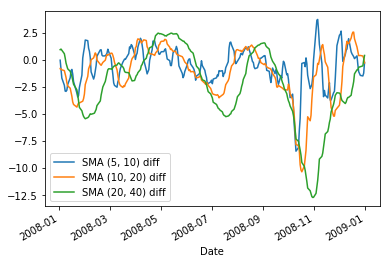

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX

In [20]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

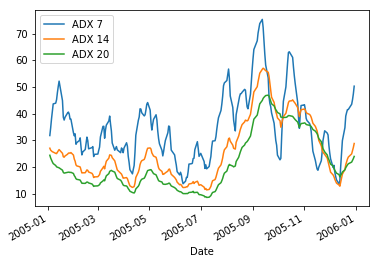

In [21]:
data['2005'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI

In [22]:
# data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

In [23]:
# data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

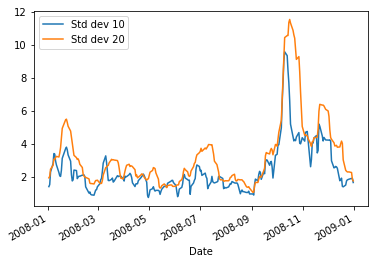

In [25]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [26]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Return scaled'] = data['Return'] / (data['Return'].rolling(return_day).std().fillna(1.0))

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD hist (14, 20, 12)",...,"SMA (5, 10) diff","SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,Std dev 10,Std dev 20,Return,Return scaled
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.644864,-0.415512,-0.046339,1.243877,6.835067,-1.793634,-2.853139,-0.432770,0.403900,-0.055075,...,-0.93437,0.93594,2.150785,20.440722,20.489020,27.166137,1.199364,1.942356,0.069504,0.055983
1999-05-06,0.175178,-0.267523,-1.595153,-0.637330,5.577426,-1.750246,-3.248888,-1.433450,0.351419,-0.091009,...,-0.78906,0.76172,1.987895,19.525417,19.845702,28.433563,1.221660,1.940844,0.081651,0.071297
1999-05-07,0.139082,1.313321,-0.598251,0.092678,4.247104,-0.453265,-2.032408,-0.610786,0.344498,-0.082864,...,-0.35781,0.67422,1.884770,18.655876,19.248335,29.519928,1.197413,1.942808,-1.226889,-1.027132
1999-05-10,0.256597,-1.001861,-1.658642,-1.455773,4.484667,-0.508662,-2.257764,-1.461731,0.309100,-0.100067,...,-0.40313,0.54688,1.661723,17.785037,18.298311,28.103513,1.084316,1.888977,-2.384535,-1.814070
1999-05-11,0.509259,1.448598,-1.138434,0.184587,3.454888,0.980149,-0.836615,-0.315329,0.329205,-0.067660,...,0.14062,0.37813,1.562503,17.270934,17.280123,24.967837,0.789305,1.897725,-4.928604,-2.476156


### Features

In [28]:
feature_names = data.drop(['Return', 'Return scaled'], axis=1).columns

# Train and test Random Forest

In [29]:
def to_class(y_vec):
    y_extreme = extreme_multiplier * y_vec.rolling(rolling_std_dev_size).std().fillna(method='bfill')
    
    pos = y_vec > y_extreme
    neg = y_vec < -1*y_extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [30]:
def make_X_y(df):
    X = df.drop(['Return', 'Return scaled'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y)
    return X, y, ret

In [31]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    ret = ret.iloc[train_size:]
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret

In [32]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad = ((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos'))
    bad_sum = -20*np.sum(bad)
    avg = ((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg'))
    avg_sum = -2*np.sum(avg)
    good = ((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg'))
    good_sum = 7*np.sum(good)
    return bad_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [34]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    params = {'n_estimators': [100],
#               'max_depth': [3,4,None],
              'max_features': [3,4],
              'min_samples_split': [2,3,4],
              'min_samples_leaf': [2,3]}
    grid = GridSearchCV(estimator=RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample', max_depth=None),
                        param_grid=params, 
                        scoring=scorer,
                        cv=3)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.iloc[0].name,
        'best_params': best_params,
        'features': best_estimator.feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 1999-05-05 00:00:00 to 2001-09-24 00:00:00
---
Distribution:
Neutral    384
Neg        181
Pos        153
Name: Return, dtype: int64
---
Distribution:
Neutral    45
Neg        44
Pos        11
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.71      0.45      0.56        44
    Neutral       0.47      0.60      0.53        45
        Pos       0.00      0.00      0.00        11

avg / total       0.53      0.47      0.48       100

---
Confusion matrix
 [[20 19  5]
 [ 8 27 10]
 [ 0 11  0]]
-14.111566614553118 [long] + 94.33486019206855 [short] = 80.22329357751543
From 1999-09-27 00:00:00 to 2002-02-15 00:00:00
---
Distribution:
Neutral    361
Neg        229
Pos        128
Name: Return, dtype: int64
---
Distribution:
Neutral    68
Neg        17
Pos        15
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.82      0.

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.17      0.50      0.25        16
    Neutral       0.60      0.62      0.61        52
        Pos       0.00      0.00      0.00        32

avg / total       0.34      0.40      0.36       100

---
Confusion matrix
 [[ 8  8  0]
 [20 32  0]
 [19 13  0]]
0.0 [long] + -22.277867860915336 [short] = -22.277867860915336
From 2001-04-27 00:00:00 to 2003-09-18 00:00:00
---
Distribution:
Neutral    372
Pos        174
Neg        172
Name: Return, dtype: int64
---
Distribution:
Neutral    57
Pos        34
Neg         9
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.10      0.33      0.15         9
    Neutral       0.69      0.70      0.70        57
        Pos       0.83      0.29      0.43        34

avg / total       0.69      0.53      0.56       100

---
Confusion matrix
 [[ 3  5  1]
 [16 40  1]
 [11 13 10]]
38.2

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        15
    Neutral       0.47      0.85      0.60        46
        Pos       0.35      0.15      0.21        39

avg / total       0.35      0.45      0.36       100

---
Confusion matrix
 [[ 0 11  4]
 [ 0 39  7]
 [ 0 33  6]]
-2.403164407715731 [long] + 0.0 [short] = -2.403164407715731
From 2005-09-14 00:00:00 to 2008-02-01 00:00:00
---
Distribution:
Neutral    346
Pos        280
Neg         92
Name: Return, dtype: int64
---
Distribution:
Neutral    49
Neg        34
Pos        17
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.03      0.06        34
    Neutral       0.47      0.51      0.49        49
        Pos       0.30      0.82      0.44        17

avg / total       0.62      0.40      0.34       100

---
Confusion matrix
 [[ 1 25  8]
 [ 0 25 24]
 [ 0  3 14]]
0.5790

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        27
    Neutral       0.42      0.46      0.44        52
        Pos       0.21      0.43      0.28        21

avg / total       0.26      0.33      0.29       100

---
Confusion matrix
 [[ 0 21  6]
 [ 0 24 28]
 [ 0 12  9]]
0.8850376534879101 [long] + 0.0 [short] = 0.8850376534879101
From 2014-01-17 00:00:00 to 2016-06-06 00:00:00
---
Distribution:
Neutral    377
Neg        179
Pos        162
Name: Return, dtype: int64
---
Distribution:
Neutral    52
Pos        43
Neg         5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.60      0.85      0.70        52
        Pos       1.00      0.23      0.38        43

avg / total       0.74      0.54      0.53       100

---
Confusion matrix
 [[ 0  5  0]
 [ 8 44  0]
 [ 9 24 10]]
41.822

In [38]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [39]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [40]:
params.sort_values('Sum of return', ascending=False)

,max_features,min_samples_leaf,min_samples_split,n_estimators,Sum of return,Accuracy
2000-02-17,3,2,3,100,96.102597,0.55
1999-05-05,3,2,3,100,80.223294,0.47
2012-01-23,4,2,4,100,72.848174,0.53
2009-04-14,4,2,3,100,49.387227,0.57
2012-11-07,4,2,2,100,48.166892,0.59
2001-09-25,4,2,3,100,46.944165,0.49
1999-09-27,3,2,4,100,39.964555,0.48
2012-06-14,4,2,2,100,36.367154,0.62
2010-11-11,4,3,3,100,33.740479,0.53
2014-06-12,4,3,3,100,32.484230,0.50


In [41]:
params.describe()

,max_features,min_samples_leaf,min_samples_split,n_estimators,Sum of return,Accuracy
count,41.000000,41.000000,41.000000,41.0,41.000000,41.000000
mean,3.512195,2.243902,2.926829,100.0,6.166928,0.450732
std,0.506061,0.434769,0.720772,0.0,37.514104,0.089062
min,3.000000,2.000000,2.000000,100.0,-84.962131,0.250000
25%,3.000000,2.000000,2.000000,100.0,-13.686035,0.400000
50%,4.000000,2.000000,3.000000,100.0,7.346027,0.460000
75%,4.000000,2.000000,3.000000,100.0,23.263470,0.530000
max,4.000000,3.000000,4.000000,100.0,96.102597,0.620000


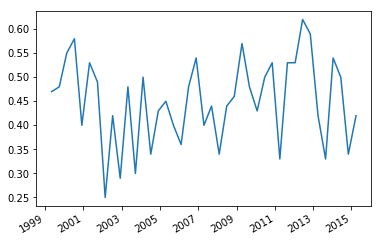

In [42]:
params['Accuracy'].plot()

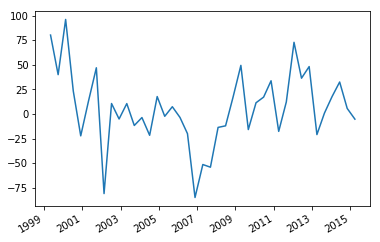

In [43]:
params['Sum of return'].plot()

### Feature importances

In [44]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [45]:
features.idxmax(axis=1).value_counts()

Std dev 20           13
ADX 20                8
SMA (20, 40) diff     6
Deviation EMA 40      5
ADX 14                3
SMA (10, 20) diff     3
Std dev 10            2
ADX 7                 1
dtype: int64

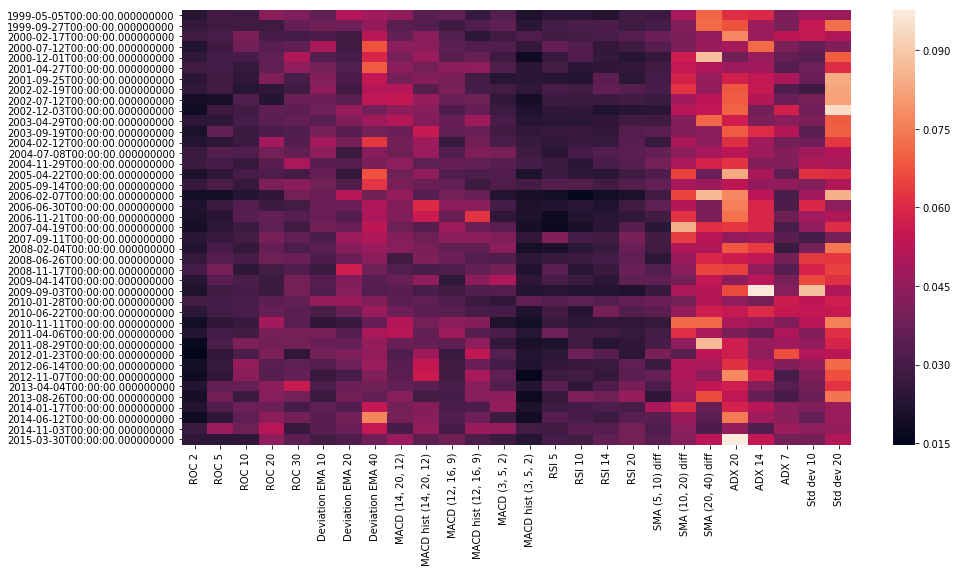

In [46]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


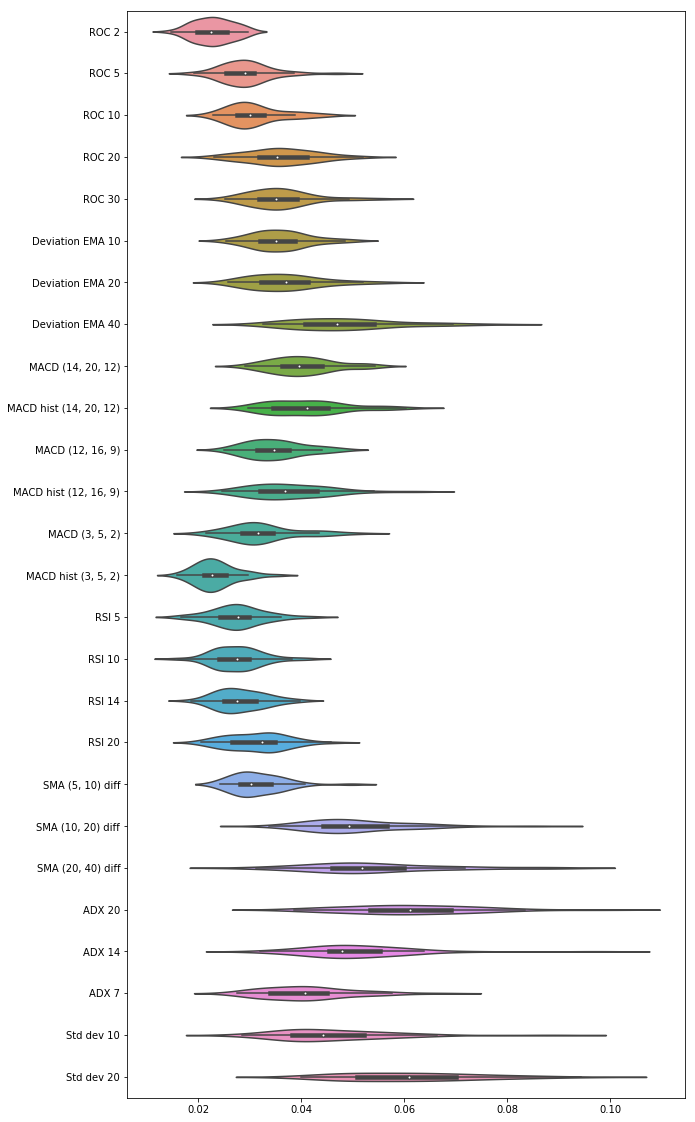

In [47]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')